In [ ]:

from nilearn import datasets, plotting
from nilearn.maskers import NiftiMapsMasker
import numpy as np
import matplotlib.pyplot as plt
from nilearn.connectome import ConnectivityMeasure
from sklearn.covariance import GraphicalLassoCV
from scipy.spatial.distance import pdist, squareform
from scipy.optimize import minimize
from nilearn import datasets
from nilearn.maskers import NiftiMapsMasker
from nilearn import plotting
import seaborn as sns
from scipy.stats import kurtosis, skew, norm
from scipy.linalg import inv

import networkx as nx

import learnHeat as lh

# data importation
atlas = datasets.fetch_atlas_msdl()
atlas_filename = atlas.maps

data = datasets.fetch_development_fmri(n_subjects=1)
fmri_filename = data.func[0]

masker = NiftiMapsMasker(maps_img=atlas_filename, standardize=True, verbose=5)
time_series = masker.fit_transform(fmri_filename)

X = time_series.T 
print(f"Forme de la matrice X : {X.shape}")


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   ------------------ --------------------- 0.5/1.2 MB 3.4 MB/s eta 0:00:01
   --------------------------- ------------ 0.8/1.2 MB 2.8 MB/s eta 0:00:01
   ---------------------------------------- 1.2/1.2 MB 1.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/887.3 kB ? eta -:--:--
   ----------- ---------------------------- 262.1/887.3 kB ? eta -:--:--
   ----------------------- ---------------- 524.3/887.3 kB 1.7 MB/s eta 0:00:01
   ----------------------------------- ---- 786.4/887.3 kB 1.5 MB/s eta 0:00:01
   ---------------------------------------- 887.3/887.3 kB 1.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/7.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/7.5 MB ? eta -:--:--
   - -------------------------------------- 0.3/7.5 MB ? eta -:--:--
   - -----------------------------

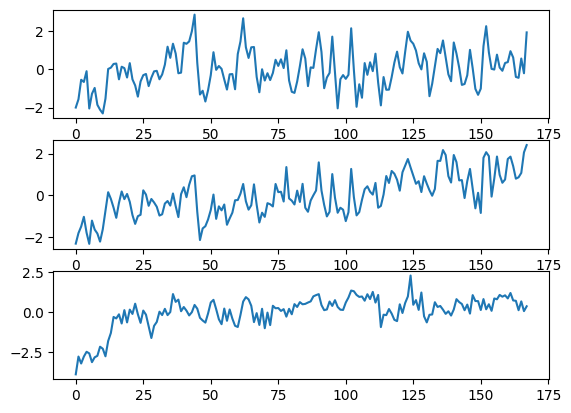

In [ ]:
# Testing the imported data
x0 = X[0,:]
x1 = X[1,:]
x2 = X[20,:]

plt.subplot(3,1,1)
plt.plot(x0)
plt.subplot(3,1,2)
plt.plot(x1)
plt.subplot(3,1,3)
plt.plot(x2)
plt.show()

### Data diagnostic

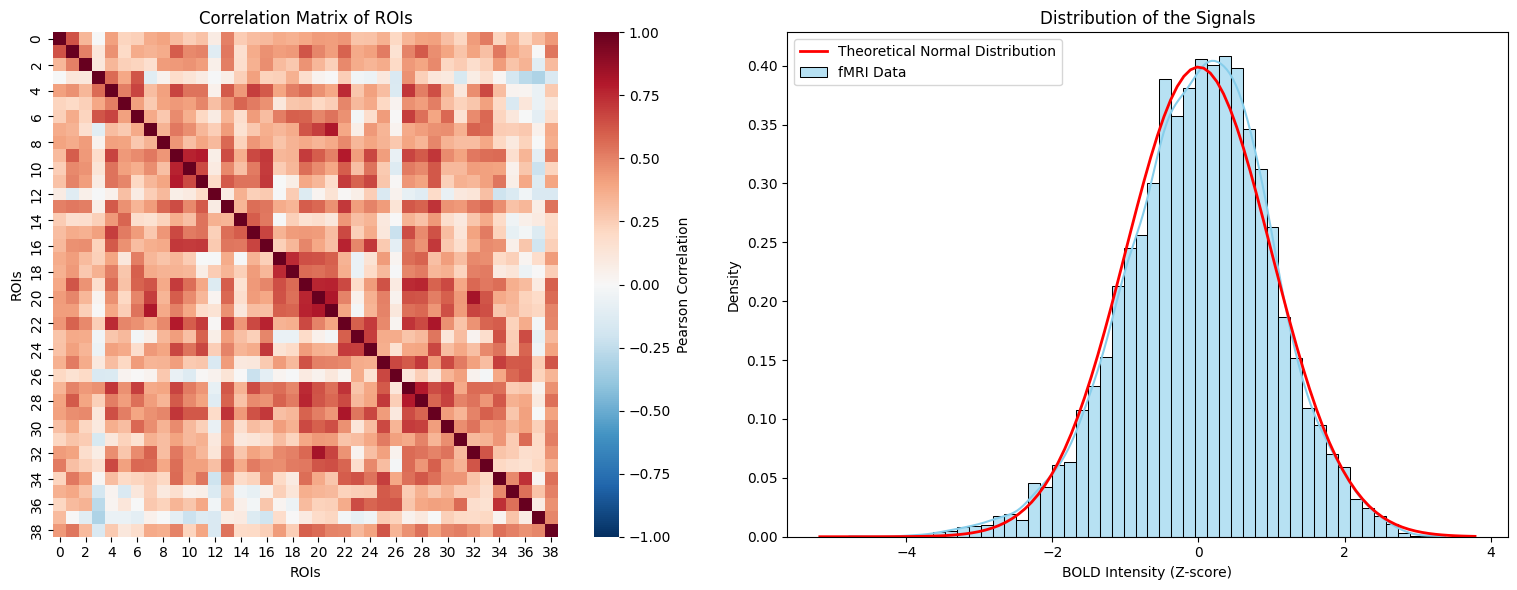

In [47]:
"""
Diagnostic du dataset fMRI selon deux critères :
A. Structure de covariance 
B. Hypothèse Gaussienne
"""


X_sujet1 = time_series

# STRUCTURE DE CORRÉLATION
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([X_sujet1])[0]

# HYPOTHÈSE GAUSSIENNE 
all_signal_values = X_sujet1.flatten()


# VISUALISATION 
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# La Matrice de Covariance/Corrélation
sns.heatmap(correlation_matrix, cmap='RdBu_r', center=0, vmin=-1, vmax=1, 
            square=True, ax=axes[0], cbar_kws={'label': 'Pearson Correlation'})
axes[0].set_title("Correlation Matrix of ROIs")
axes[0].set_xlabel("ROIs")
axes[0].set_ylabel("ROIs")

# Histogramme vs Loi Normale
# Ce plot valide l'hypothèse X ~ N(0, Sigma)
sns.histplot(all_signal_values, bins=50, stat="density", kde=True, 
             color="skyblue", edgecolor='black', alpha=0.6, ax=axes[1], label="fMRI Data")

# Superposition de la courbe théorique Gaussienne
xmin, xmax = axes[1].get_xlim()
x_axis = np.linspace(xmin, xmax, 100)
p = norm.pdf(x_axis, 0, 1) # Car les données sont standardisées
axes[1].plot(x_axis, p, 'r', linewidth=2, label="Theoretical Normal Distribution")

axes[1].set_title(f"Distribution of the Signals")
axes[1].set_xlabel("BOLD Intensity (Z-score)")
axes[1].legend()

plt.tight_layout()
plt.show()

### Statistical method - II-A of the article

c:\Users\victo\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


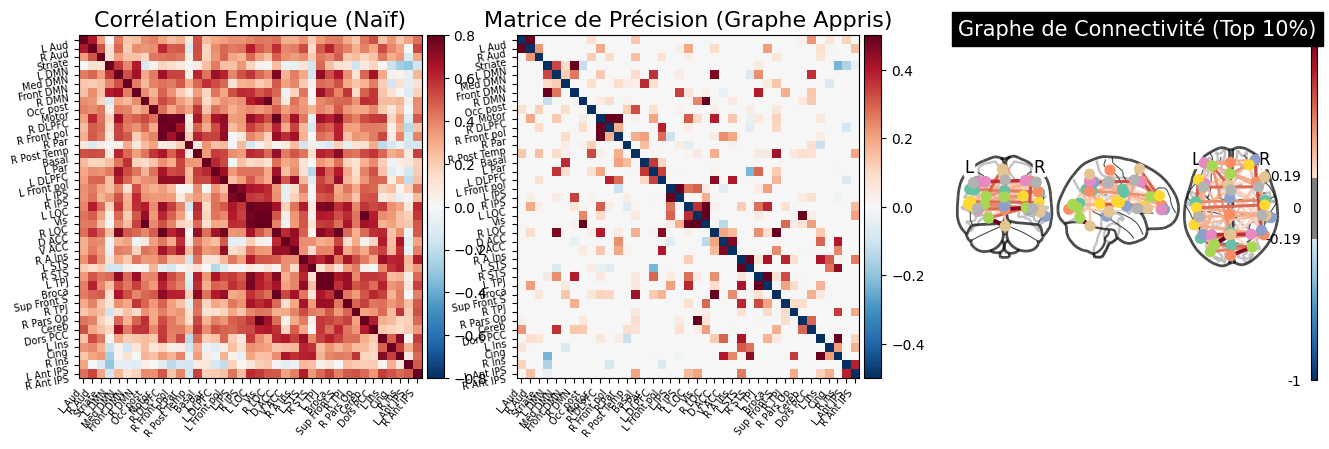

In [28]:
# We use the Graphical Lasso method
gl_model = GraphicalLassoCV(cv=5, max_iter=1000)
gl_model.fit(time_series)

precision_matrix = gl_model.precision_
covariance_matrix = gl_model.covariance_


# Plotting 
coords = atlas.region_coords

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Correlation between the time series at each node
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([time_series])[0]
plotting.plot_matrix(correlation_matrix, labels=atlas.labels, colorbar=True,
                     vmax=0.8, vmin=-0.8, axes=axes[0], title="Corrélation Empirique (Naïf)")

# Plotting the adjacency matrix constructed by this method and the associated connectome
plotting.plot_matrix(-precision_matrix, labels=atlas.labels, colorbar=True,
                     vmax=0.5, vmin=-0.5, axes=axes[1], title="Matrice de Précision (Graphe Appris)")

plotting.plot_connectome(-precision_matrix, coords,
                         edge_threshold='90%', title="Graphe de Connectivité (Top 10%)",
                         axes=axes[2])
plt.show()

### Method based on global smoothness - IIIA of the article 

   Itération 1: Changement Y = 0.13824
   Itération 2: Changement Y = 0.06274
   Itération 3: Changement Y = 0.00954
   Itération 4: Changement Y = 0.00006
   Convergence atteinte.


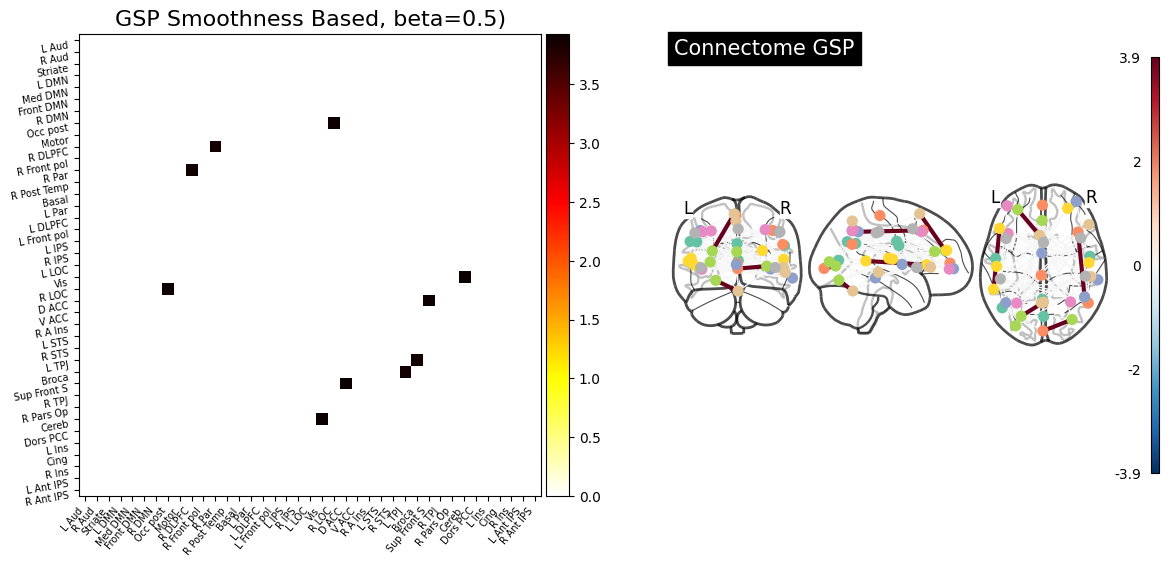

In [ ]:
""" 
 Implémentation de la méthode GSP smoothness based
 Méthode III.A de Dong et al. 
 """



def graph_learning_loss_L_step(w_vector, dist_sq_Y, alpha, beta, n_nodes, idx_upper):
    """
    Fonction objectif pour l'étape L (Graph Learning) de l'Eq. (20).
    Minimise: alpha * tr(Y.T * L * Y) + beta * ||L||_F^2
    """
    W = np.zeros((n_nodes, n_nodes))
    W[idx_upper] = w_vector
    W = W + W.T
    
    degrees = np.sum(W, axis=1)
    L = np.diag(degrees) - W
    
    # Terme Smoothness (tr(Y^T L Y))
    # tr(Y^T L Y) est exactement la somme pondérée des distances au carré dans Y
    smoothness = np.sum(w_vector * dist_sq_Y[idx_upper])
    
    # Terme Régularisation (||L||_F^2)
    regularization = np.sum(L**2)
    
    return alpha * smoothness + beta * regularization

def solve_full_graph_learning(X, alpha=1.0, beta=0.5, max_iter=10, tol=1e-3):
    """
    Résout l'équation (20) complète par minimisation alternée.
    X: Données brutes (Noeuds x Temps)
    """
    n_nodes = X.shape[0]
    idx_upper = np.triu_indices(n_nodes, k=1)
    
    # Initialisation : On suppose au début que le signal propre Y est égal aux données X
    Y = X.copy()
    L_current = np.eye(n_nodes) 
        
    for i in range(max_iter):
        Y_old = Y.copy()
        
        #  Mise à jour de L 
        # On fixe Y, on cherche L.
        dist_sq_Y = squareform(pdist(Y, metric='sqeuclidean'))
        
        # Définition des contraintes et bornes pour L
        cons = [{'type': 'eq', 'fun': lambda w: 2 * np.sum(w) - n_nodes}] # tr(L) = N
        bounds = [(0, None) for _ in range(len(idx_upper[0]))] 
        init_w = np.ones(len(idx_upper[0]))
        
        # Résolution de l'optimisation pour L
        res = minimize(
            graph_learning_loss_L_step, 
            init_w, 
            args=(dist_sq_Y, alpha, beta, n_nodes, idx_upper),
            method='SLSQP', 
            bounds=bounds, 
            constraints=cons,
            options={'maxiter': 100}
        )
        
        # Reconstruction de L optimal
        w_opt = res.x
        W_opt = np.zeros((n_nodes, n_nodes))
        W_opt[idx_upper] = w_opt
        W_opt = W_opt + W_opt.T
        L_new = np.diag(np.sum(W_opt, axis=1)) - W_opt
        
        # Mise à jour de Y (Signal Denoising) 
        # On fixe L, on cherche Y.
        I = np.eye(n_nodes)
        Y_new = inv(I + alpha * L_new) @ X
        
        # --- Vérification de la convergence ---
        diff = np.linalg.norm(Y_new - Y_old) / np.linalg.norm(Y_old)
        print(f"   Itération {i+1}: Changement Y = {diff:.5f}")
        
        Y = Y_new
        L_current = L_new
        
        if diff < tol:
            print("   Convergence atteinte.")
            break
            
    return W_opt, Y 

beta_param = 0.5
w_opt, Y_denoised = solve_full_graph_learning(X, alpha=1.0, beta=beta_param, max_iter=10, tol=1e-3)
W_gsp = w_opt

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

corr_matrix = np.corrcoef(X)

plotting.plot_matrix(W_gsp, labels=atlas.labels, colorbar=True, cmap='hot_r',
                     axes=axes[0], title=f"GSP Smoothness Based, beta={beta_param})")

plotting.plot_connectome(W_gsp, atlas.region_coords, edge_threshold='90%', 
                         title="Connectome GSP",axes=axes[1])
plt.show()



Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 1157.4943974740368
            Iterations: 12
            Function evaluations: 5940
            Gradient evaluations: 8


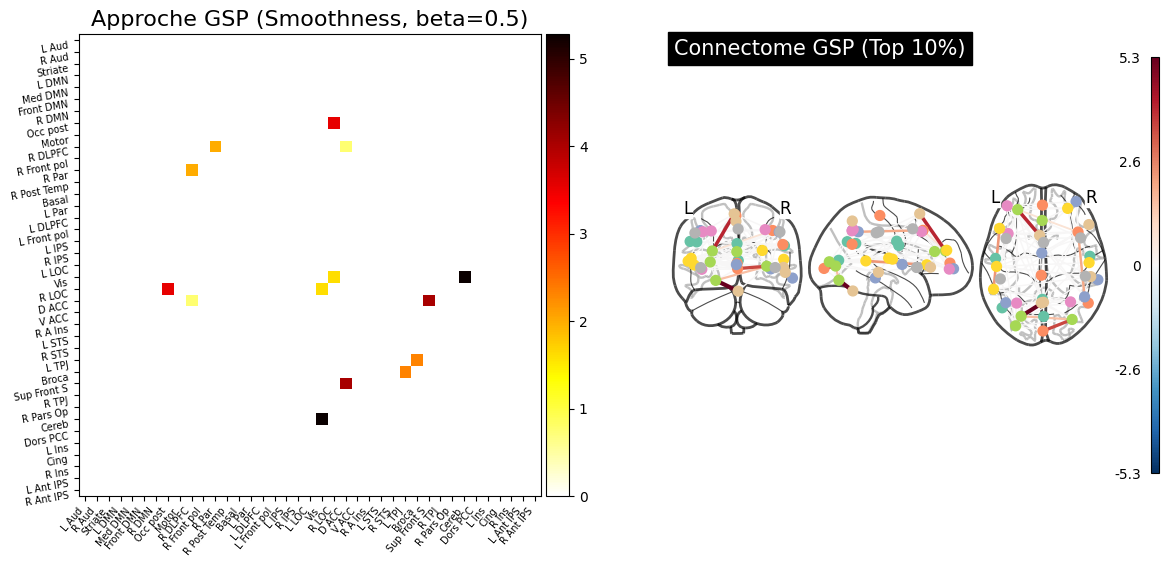

In [ ]:
""" 
 Implémentation de la méthode GSP smoothness based, avec l'hypothèse simplificatrice X=Y.
 Méthode III.A de Dong et al. 
 """

from scipy.optimize import minimize


X = time_series.T
n_nodes = X.shape[0]

dist_matrix_sq = squareform(pdist(X, metric='sqeuclidean'))

idx_upper = np.triu_indices(n_nodes, k=1)

def graph_learning_objective_simplified(w_vector, dist_sq, beta):
    """
    Fonction objectif simplifiée (hypothèse X=Y) : Smoothness + Régularisation
    J(L) = tr(X.T * L * X) + beta * ||L||_F^2
    """
    W = np.zeros((n_nodes, n_nodes))
    W[idx_upper] = w_vector
    W = W + W.T
    
    degrees = np.sum(W, axis=1)
    L = np.diag(degrees) - W
    
    smoothness = np.sum(w_vector * dist_sq[idx_upper])
    
    regularization = np.sum(L**2)
    
    return smoothness + beta * regularization


def constraint_trace(w_vector):
    return 2 * np.sum(w_vector) - n_nodes

def GSP_Smoothness_simplified(beta_param, initial_guess, bounds, constraints):
        
    result = minimize(
        graph_learning_objective_simplified, 
        initial_guess, 
        args=(dist_matrix_sq, beta_param),
        method='SLSQP', 
        bounds=bounds, 
        constraints=constraints,
        options={'maxiter': 1000, 'disp': True}
    )

    return result.x


beta_param = 0.5  
initial_guess = np.ones(len(idx_upper[0])) * (n_nodes / (2 * len(idx_upper[0]))) 
bounds = [(0, None) for _ in range(len(initial_guess))] 
constraints = [{'type': 'eq', 'fun': constraint_trace}]

w_opt = GSP_Smoothness_simplified(beta_param, initial_guess, bounds, constraints)
W_gsp = np.zeros((n_nodes, n_nodes))
W_gsp[idx_upper] = w_opt
W_gsp = W_gsp + W_gsp.T


fig, axes = plt.subplots(1, 2, figsize=(14, 6))

corr_matrix = np.corrcoef(X)

plotting.plot_matrix(W_gsp, labels=atlas.labels, colorbar=True, cmap='hot_r',
                     axes=axes[0], title=f"Approche GSP (Smoothness, beta={beta_param})")

plotting.plot_connectome(W_gsp, atlas.region_coords, edge_threshold='90%', 
                         title="Connectome GSP (Top 10%)",axes=axes[1])
plt.show()

### Spectral filtering - IIIB of the article 

#### Stationarity based 

Optimization terminated successfully    (Exit mode 0)
            Current function value: 7.929279440296498e-14
            Iterations: 3
            Function evaluations: 120
            Gradient evaluations: 3


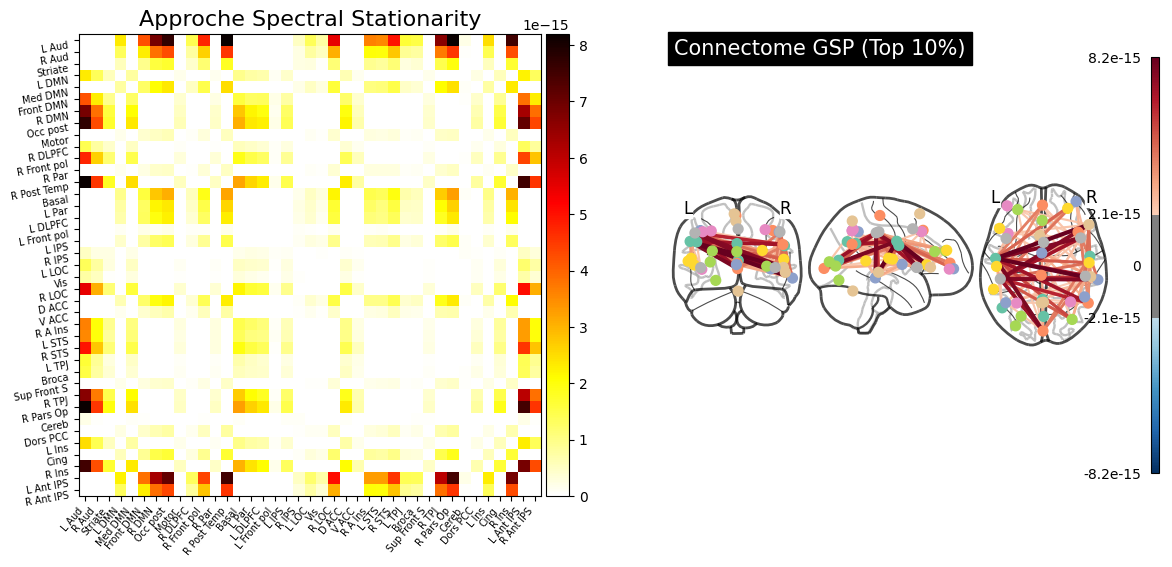

In [37]:
empirical_covariance_matrix = np.cov(X)
_, chi = np.linalg.eigh(empirical_covariance_matrix)

n_nodes = X.shape[0]
idx_upper = np.triu_indices(n_nodes, k=1)

def graph_learning_objective(lambda_vector):
    """
    Fonction objectif : 
    J(L) = ||L||_F^2 
    """
    return np.linalg.norm(lambda_vector)

def constraint_w(lambda_vector):
    L = chi@np.diag(lambda_vector)@chi.T
    w_vector = -L[idx_upper]
    return w_vector # We want positive edge weights

def constraint_d(lambda_vector):
    L = chi@np.diag(lambda_vector)@chi.T
    D = np.identity(n_nodes)*L
    W = D-L
    return np.sum(W, axis=1)-[D[i,i] for i in range(n_nodes)] # We want the degrees to correspond to the edge weights

# def constraint_trace(lambda_vector):
#     return np.sum(lambda_vector)-n_nodes

initial_guess = np.ones(n_nodes)
bounds = [(0, None) for _ in range(len(initial_guess))] 
constraints = [
    {'type': 'ineq', 'fun': constraint_w},
    {'type': 'eq', 'fun': constraint_d}, 
    # {'type': 'eq', 'fun': constraint_trace}
]

result = minimize(
    graph_learning_objective, 
    initial_guess, 
    method='SLSQP', 
    bounds=bounds,
    constraints=constraints,
    options={'maxiter': 1000, 'disp': True}
)

lambda_opt = result.x
L = chi@np.diag(lambda_opt)@chi.T
D = np.identity(n_nodes)*L
W = D-L

# We only keep the positive edge weights 
threshold = 0
W = np.maximum(W-threshold, 0)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plotting.plot_matrix(W, labels=atlas.labels, colorbar=True, cmap='hot_r',
                     axes=axes[0], title=f"Approche Spectral Stationarity")

plotting.plot_connectome(W, atlas.region_coords, edge_threshold='90%', 
                         axes=axes[1], title="Connectome GSP (Top 10%)")
plt.show()

#### Graph dictionary based

In [40]:
n_nodes = X.shape[0]

rg = nx.fast_gnp_random_graph(n_nodes, p = 0.4)
L0 = nx.laplacian_matrix(rg).toarray()
L0 = L0/np.trace(L0)*n_nodes
tau0 = [1, 2]
H0 = np.random.rand(lh.D(L0, tau0).shape[1], X.shape[1])

# alpha_values = [1e-2, 1e-1, 1]
# beta_values = [1e-2, 1e-1, 1]


result = lh.learn_heat(X = X, 
            L0=L0, H0 = H0, tau0=tau0, 
            verbose=False, 
            max_iter = 50, alpha=.1, beta=.1)


Learning progress: 100%|██████████| 50/50 [04:32<00:00,  5.44s/it]
COST: 532.23038 (tau updated)


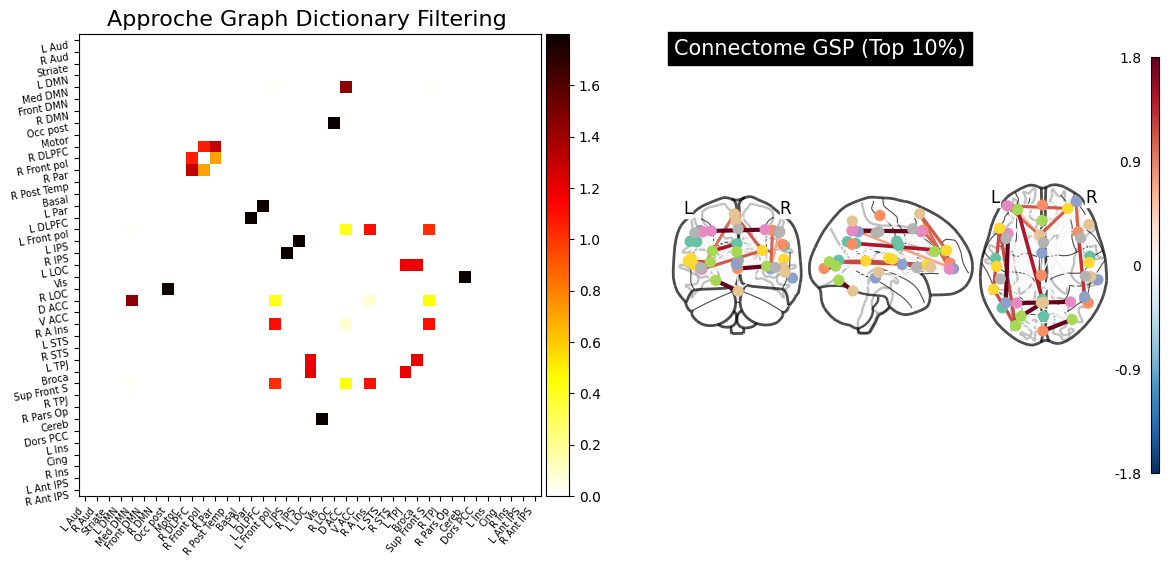

In [41]:
laplacian_matrix = result['L']
mask_diagonal = np.ones_like(laplacian_matrix) - np.identity(laplacian_matrix.shape[0])
adjacency_matrix = - laplacian_matrix*mask_diagonal


fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plotting.plot_matrix(adjacency_matrix, labels=atlas.labels, colorbar=True, cmap='hot_r',
                     axes=axes[0], title=f"Approche Graph Dictionary Filtering ")

plotting.plot_connectome(adjacency_matrix, atlas.region_coords, edge_threshold='90%', 
                         axes=axes[1], title="Connectome GSP (Top 10%)")
plt.show()

### Age prediction 

[fetch_atlas_msdl] Dataset found in C:\Users\alex\nilearn_data\msdl_atlas
[fetch_development_fmri] Dataset found in C:\Users\alex\nilearn_data\development_fmri
[fetch_development_fmri] Dataset found in C:\Users\alex\nilearn_data\development_fmri\development_fmri
[fetch_development_fmri] Dataset found in C:\Users\alex\nilearn_data\development_fmri\development_fmri
Population : 79 Enfants, 21 Adultes
Apprentissage des graphes GSP pour chaque sujet...
Format des données d'entrée du classifieur : (100, 741)
------------------------------
PRÉCISION DE CLASSIFICATION : 66.67%
------------------------------


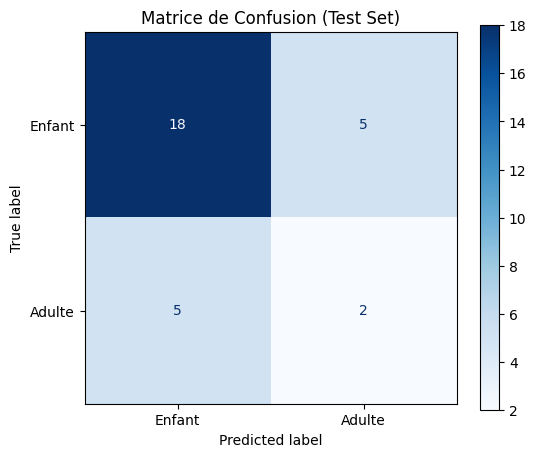

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.optimize import minimize
from nilearn import datasets
from nilearn.maskers import NiftiMapsMasker
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from nilearn import plotting


atlas = datasets.fetch_atlas_msdl()
data = datasets.fetch_development_fmri(n_subjects=100) 

ages = data.phenotypic['Age']
y = np.array([0 if age < 18 else 1 for age in ages])
labels_name = ["Enfant", "Adulte"]

print(f"Population : {np.sum(y==0)} Enfants, {np.sum(y==1)} Adultes")

# Extraction des signaux
masker = NiftiMapsMasker(maps_img=atlas.maps, standardize=True, verbose=0)
subjects_timeseries = []

for func_file in data.func:
    ts = masker.fit_transform(func_file)
    subjects_timeseries.append(ts.T) # Format (Noeuds x Temps)

print("Apprentissage des graphes GSP pour chaque sujet...")
X_features = []
graphs_viz = [] # Pour visualisation

"""
for i, ts in enumerate(subjects_timeseries):
    # On apprend le graphe W pour le sujet i
    W = GSP_Smoothness_simplified(ts, beta=1.0)
    graphs_viz.append(W)
    
    upper_tri = W[np.triu_indices(W.shape[0], k=1)]
    X_features.append(upper_tri)

X_features = np.array(X_features)
"""
X_features = np.load("results_gsp_smoothness.npz")['X_features']
print(f"Format des données d'entrée du classifieur : {X_features.shape}")

# Séparation Train / Test
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.3, random_state=42)

# Modèle : SVM Linéaire (Robuste pour peu d'échantillons et beaucoup de features)
clf = LinearSVC(dual=False, random_state=42)
clf.fit(X_train, y_train)

# Évaluation
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print("-" * 30)
print(f"PRÉCISION DE CLASSIFICATION : {acc*100:.2f}%")
print("-" * 30)

fig, ax = plt.subplots(figsize=(6, 5))  # On crée une seule figure, pas 3

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_name)

disp.plot(ax=ax, cmap='Blues')
ax.set_title("Confusion Matrix (Test Set)")

plt.show()